In [20]:
import os
import copy
import torch
import mne

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.metrics import accuracy_score

from braindecode.models import SleepStagerChambon2018

from skada.deepda import DeepCORAL, DeepJDOT, BaseDANetwork

device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline

# Load sleep Physionet dataset

In [2]:

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [3]:
subjects = range(3)
recordings = [1]

In [4]:
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn', path='.')

In [5]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [6]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

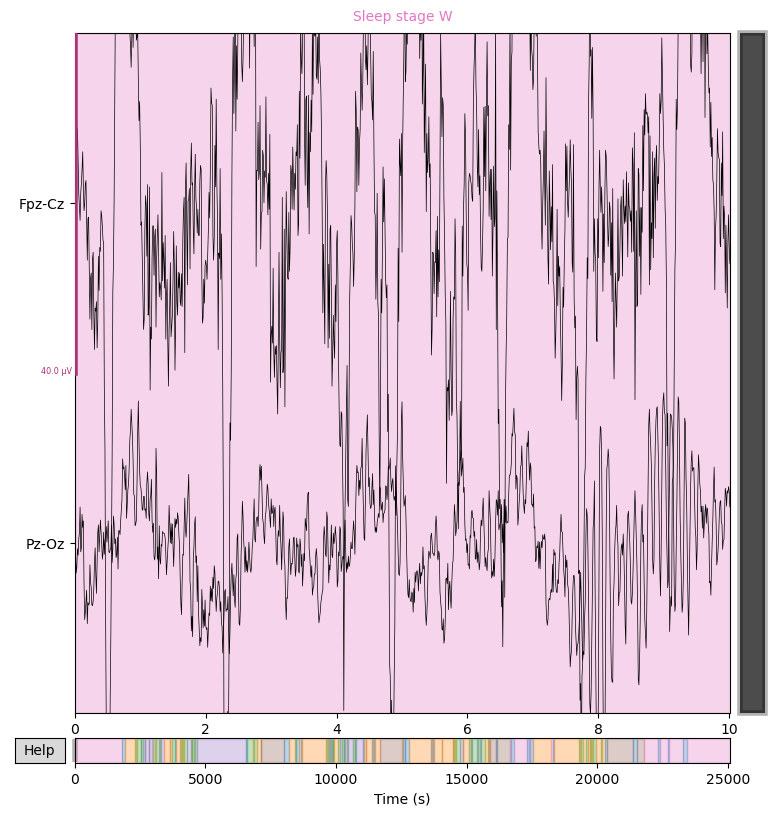

In [7]:
# Plot a recording as a sanity check
raws[0].plot();

In [12]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place

In [13]:

def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [14]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data.astype("float32")
        self.epochs_labels = epochs_labels.astype("int64")
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [15]:
# Apply windowing and move to pytorch dataset
dataset_per_patient = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]


## Define model for sleep staging

In [16]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels
model = SleepStagerChambon2018(n_channels=n_channels, sfreq=sfreq)

In [17]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cuda'.


## Classic training

In [18]:
method_classique = DeepCORAL(model, layer_names=["feature_extractor"])
method_classique.fit(dataset=dataset_per_patient[:2], dataset_target=None)


In [21]:
label_predict = method_classique.predict(dataset_per_patient[2])
true_label = dataset_per_patient[2].epochs_labels
accuracy_score(label_predict, true_label)


0.7401960784313726

In [22]:
model_pre_train = method_classique.best_model()

## DeepJDOT method

In [28]:
from sklearn.utils.class_weight import compute_class_weight
true_label = dataset_per_patient[0].epochs_labels

class_weights = compute_class_weight(
        "balanced", classes=np.unique(true_label), y=true_label
    )

In [34]:
n_classes=5
method_deepjdot = DeepJDOT(
    model_pre_train, 
    layer_names=["feature_extractor"], 
    n_classes=n_classes, 
    alpha=0.1, 
    beta=0.1,
    class_weights=class_weights
)
method_deepjdot.fit(dataset=dataset_per_patient[:2], dataset_target=dataset_per_patient[2])


In [35]:
label_predict = method_deepjdot.predict(dataset_per_patient[2])
true_label = dataset_per_patient[2].epochs_labels
accuracy_score(label_predict, true_label)


0.7225490196078431

## DeepCoral method

In [32]:
method_deepcoral = DeepCORAL(model, layer_names=["feature_extractor"], alpha=10)
method_deepcoral.fit(dataset=dataset_per_patient[:2], dataset_target=dataset_per_patient[2])


In [33]:
label_predict = method_deepcoral.predict(dataset_per_patient[2])
true_label = dataset_per_patient[2].epochs_labels
accuracy_score(label_predict, true_label)



0.8009803921568628